In [1]:
import os
import sys
from typing import Optional

if "PyTorch_VAE" not in sys.path:
    sys.path.append("PyTorch_VAE")

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import trange

from PyTorch_VAE import models
from diffusion_policy.common.pytorch_util import compute_conv_output_shape
from diffusion_policy.dataset.pusht_image_dataset import PushTImageDataset

In [2]:
path = "/nas/ucb/ebronstein/lsdp/diffusion_policy/data/pusht/pusht_cchi_v7_replay.zarr"
# path = "/home/tsadja/data_diffusion/pusht/pusht_cchi_v7_replay.zarr"

dataset = PushTImageDataset(path)
full_dataset = torch.from_numpy(dataset.replay_buffer["img"]).permute(0, 3, 1, 2)

In [3]:
def normalize(data):
    data /= 255.0
    data = 2 * data - 1
    return data


def unnormalize(data):
    data = (data + 1) / 2
    data *= 255
    return data

In [4]:
class VanillaVAE(models.VanillaVAE):

    def __init__(
        self,
        in_channels: int,
        in_height: int,
        in_width: int,
        latent_dim: int,
        hidden_dims: Optional[list] = None,
        **kwargs
    ) -> None:
        models.BaseVAE.__init__(self)

        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        kernel_size = 3
        stride = 2
        padding = 1
        dilation = 1
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                        dilation=dilation,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        self.conv_out_shape = compute_conv_output_shape(
            H=in_height,
            W=in_width,
            padding=padding,
            stride=stride,
            kernel_size=kernel_size,
            dilation=dilation,
            num_layers=len(hidden_dims),
            last_hidden_dim=hidden_dims[-1],
        )
        conv_out_size = np.prod(self.conv_out_shape)

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(conv_out_size, latent_dim)
        self.fc_var = nn.Linear(conv_out_size, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, conv_out_size)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                hidden_dims[-1],
                hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, *self.conv_out_shape)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

In [4]:
from vae.pusht_vae import VanillaVAE

In [5]:
full_dataset = normalize(full_dataset)
N, C, H, W = full_dataset.shape
train_split = 0.8
train_size = int(train_split * N)
val_size = N - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaVAE(in_channels=3, in_height=H, in_width=W, latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
epochs = 20

for epoch in trange(epochs):
    total_train_loss = 0
    model.train()
    for i, x in enumerate(train_loader):
        x = x.to(device)
        result = model(x)
        loss = model.loss_function(*result, M_N=1e-6)["loss"]
        # loss = loss['loss']
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Train loss:")
    print(total_train_loss / len(train_loader))

    total_val_loss = 0
    model.eval()
    with torch.no_grad():
        for i, x in enumerate(val_loader):
            x = x.to(device)
            result = model(x)
            loss = model.loss_function(*result, M_N=1e-6)["loss"]
            total_val_loss += loss.item()
    print("Validation loss:")
    print(total_val_loss / len(val_loader))

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss:
0.014095829053407657


  5%|▌         | 1/20 [00:06<02:03,  6.51s/it]

Validation loss:
0.005338332066254586
Train loss:
0.004667264720529457


 10%|█         | 2/20 [00:12<01:48,  6.00s/it]

Validation loss:
0.004173565531577568
Train loss:
0.003900933558501396


 15%|█▌        | 3/20 [00:18<01:42,  6.02s/it]

Validation loss:
0.0037405772976322757
Train loss:
0.003443529726386163


 20%|██        | 4/20 [00:24<01:39,  6.24s/it]

Validation loss:
0.003387355644788061
Train loss:
0.003099666744821656


 25%|██▌       | 5/20 [00:30<01:30,  6.02s/it]

Validation loss:
0.003011365465947097
Train loss:
0.002816350724783108


 30%|███       | 6/20 [00:36<01:22,  5.89s/it]

Validation loss:
0.00281707482464519
Train loss:
0.002600190680505957


 35%|███▌      | 7/20 [00:41<01:15,  5.81s/it]

Validation loss:
0.002636187907990924
Train loss:
0.0024374897194289345


 40%|████      | 8/20 [00:47<01:10,  5.88s/it]

Validation loss:
0.002564836613058766
Train loss:
0.002285203858201807


 45%|████▌     | 9/20 [00:53<01:03,  5.80s/it]

Validation loss:
0.002373206487029606
Train loss:
0.002164875472514278


 50%|█████     | 10/20 [00:59<00:57,  5.80s/it]

Validation loss:
0.0022661214266319453
Train loss:
0.002048261843714573


 55%|█████▌    | 11/20 [01:05<00:52,  5.88s/it]

Validation loss:
0.0021539712556122993
Train loss:
0.0019468039176658933


 60%|██████    | 12/20 [01:10<00:46,  5.85s/it]

Validation loss:
0.0021222253888266984
Train loss:
0.0018719195872777348


 65%|██████▌   | 13/20 [01:16<00:40,  5.81s/it]

Validation loss:
0.001991921386490605
Train loss:
0.0017780482691402237


 70%|███████   | 14/20 [01:22<00:34,  5.77s/it]

Validation loss:
0.0020171052715538635
Train loss:
0.0017264197155110817


 75%|███████▌  | 15/20 [01:28<00:29,  5.89s/it]

Validation loss:
0.0018762631084399749
Train loss:
0.0016535703559562773


 80%|████████  | 16/20 [01:34<00:23,  5.88s/it]

Validation loss:
0.0018626531168112752
Train loss:
0.0016108734781253283


 85%|████████▌ | 17/20 [01:40<00:17,  5.86s/it]

Validation loss:
0.0018257445602255485
Train loss:
0.001551161776586926


 90%|█████████ | 18/20 [01:46<00:11,  5.89s/it]

Validation loss:
0.0017808146654738125
Train loss:
0.001507026672318311


 95%|█████████▌| 19/20 [01:51<00:05,  5.86s/it]

Validation loss:
0.0017611870436599444
Train loss:
0.0014655940565411175


100%|██████████| 20/20 [01:57<00:00,  5.88s/it]

Validation loss:
0.0017180004003833724


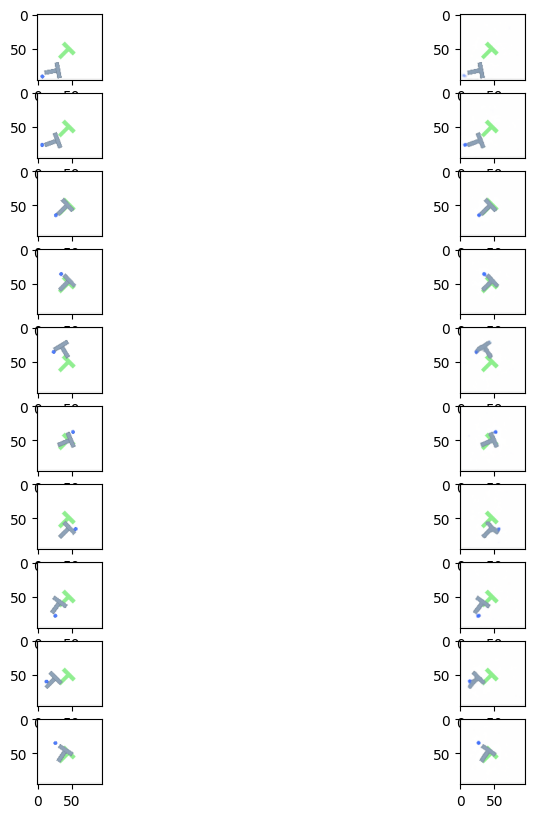

In [8]:
def show_reconstructions(model: VanillaVAE, val_loader: torch.utils.data.DataLoader):
    val_data = next(iter(val_loader))
    num_samples = 10
    val_data = val_data.to(device)
    result = model(val_data)
    recon = result[0]
    recon = unnormalize(recon)
    val_data = unnormalize(val_data)

    fig, ax = plt.subplots(num_samples, 2)
    fig.set_size_inches(10, 10)
    for i in range(num_samples):
        ax[i, 0].imshow(
            val_data[i].permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
        )
        ax[i, 1].imshow(
            recon[i].permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8)
        )
    plt.show()


show_reconstructions(model, val_loader)

In [10]:
# Save the model
# save_dir = "models/pusht_vae"
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
# torch.save(model.state_dict(), os.path.join(save_dir, "vae_32_20240403.pt"))

In [7]:
# Load the VAE
model = VanillaVAE(in_channels=3, in_height=H, in_width=W, latent_dim=32).to(device)
save_dir = "models/pusht_vae"
model.load_state_dict(torch.load(os.path.join(save_dir, "vae_32_20240403.pt")))

<All keys matched successfully>

In [11]:
# Encode the full dataset
model.eval()
with torch.no_grad():
    mu, log_var = model.encode(full_dataset.to(device))
    mu = mu.cpu().detach().numpy()
    log_var = log_var.cpu().detach().numpy()

In [12]:
mu.shape, log_var.shape

((25650, 32), (25650, 32))